# Winoground CLIP

# Install Dependencies

In [1]:
!pip install transformers
!pip install datasets

# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [2]:
def get_token():
    with open("../token.txt") as f:
        return f.read()

In [3]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
auth_token = get_token()
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Reusing dataset winoground (/gaueko0/users/jetxaniz007/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Load CLIP

In [4]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

Downloading:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Look at an example from Winoground and get the image-caption scores from CLIP

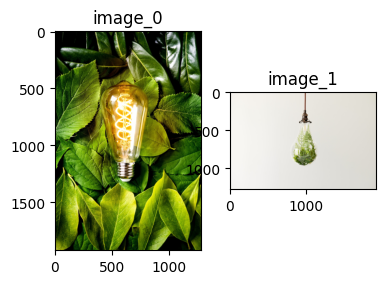

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [5]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)

In [6]:
def get_clip_scores(id):
    # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
    # Note that we could run this example through CLIP as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
    input_c0_i0 = clip_processor(text=[winoground[id]["caption_0"]], images=[winoground[id]["image_0"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c1_i0 = clip_processor(text=[winoground[id]["caption_1"]], images=[winoground[id]["image_0"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c0_i1 = clip_processor(text=[winoground[id]["caption_0"]], images=[winoground[id]["image_1"].convert("RGB")], return_tensors="pt").to("cuda")
    input_c1_i1 = clip_processor(text=[winoground[id]["caption_1"]], images=[winoground[id]["image_1"].convert("RGB")], return_tensors="pt").to("cuda")
    output_c0_i0 = clip_model(**input_c0_i0)
    output_c1_i0 = clip_model(**input_c1_i0)
    output_c0_i1 = clip_model(**input_c0_i1)
    output_c1_i1 = clip_model(**input_c1_i1)
    clip_score_c0_i0 = output_c0_i0.logits_per_image.item()
    clip_score_c1_i0 = output_c1_i0.logits_per_image.item()
    clip_score_c0_i1 = output_c0_i1.logits_per_image.item()
    clip_score_c1_i1 = output_c1_i1.logits_per_image.item()

    clip_scores = {"id": id, "c0_i0": clip_score_c0_i0, "c0_i1": clip_score_c0_i1, "c1_i0": clip_score_c1_i0, "c1_i1": clip_score_c1_i1}
    return clip_scores

clip_scores = get_clip_scores(id=155)

In [7]:
def print_scores(scores):
    print("image_0, caption_0:", scores["c0_i0"])
    print("image_0, caption_1:", scores["c1_i0"])
    print("image_1, caption_0:", scores["c0_i1"])
    print("image_1, caption_1:", scores["c1_i1"])

print("CLIP image-text match scores:")
print_scores(clip_scores)

CLIP image-text match scores:
image_0, caption_0: 29.591703414916992
image_0, caption_1: 32.436954498291016
image_1, caption_0: 35.478633880615234
image_1, caption_1: 33.82323455810547


# Get CLIP image-caption scores from the whole dataset

In [8]:
from tqdm import tqdm

def get_all_clip_scores():  
    winoground_clip_scores = []
    for id in tqdm(range(len(winoground))):
        clip_scores = get_clip_scores(id=id)
        winoground_clip_scores.append(clip_scores)
    return winoground_clip_scores

winoground_clip_scores = get_all_clip_scores()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:13<00:00,  1.28it/s]


In [9]:
def save_results(filename, winoground_scores):
    with open(filename, 'w') as f:
        for scores in winoground_scores:
            f.write(f'{{"label": "{scores["id"]}_c0_i0", "score": {scores["c0_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i0", "score": {scores["c1_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c0_i1", "score": {scores["c0_i1"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i1", "score": {scores["c1_i1"]}}}\n')

save_results("../results/scores/clip_h14_laion.jsonl", winoground_clip_scores)

# Define the text, image, and group metrics, and compute the overall performance of CLIP

In [10]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def print_performance(winoground_scores):
    text_correct_count = 0
    image_correct_count = 0
    group_correct_count = 0
    for result in winoground_scores:
        text_correct_count += 1 if text_correct(result) else 0
        image_correct_count += 1 if image_correct(result) else 0
        group_correct_count += 1 if group_correct(result) else 0

    denominator = len(winoground_scores)
    print("text score:", text_correct_count/denominator)
    print("image score:", image_correct_count/denominator)
    print("group score:", group_correct_count/denominator)

print("CLIP scores:")
print_performance(winoground_clip_scores)

CLIP scores:
text score: 0.33
image score: 0.13
group score: 0.105
